## Experiment: Customer model with less trees
---

Let's get a sense of how would the customer model behave when they have less trees!

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm
import copy

from src.utils import scale_scores
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

In [3]:
with open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb') as f:
    model = pickle.load(f)

### Data Processing
---

In [4]:
from utils import preprocess

In [17]:
# modeling_df
modeling_df = pd.read_feather('../../artifacts/modeling_df_final_with_oof_preds_replication.feather')
modeling_df = preprocess(modeling_df)

In [6]:
# get all and combine test_dfs
dfs = {}
dfs['jan'] = pd.read_feather('../../artifacts/oot_unscored_2020-01-06.feather')
dfs['feb'] = pd.read_feather('../../artifacts/oot_unscored_2020-02-17.feather')
dfs['mar'] = pd.read_feather('../../artifacts/oot_unscored_2020-03-15.feather')
dfs['apr'] = pd.read_feather('../../artifacts/oot_unscored_2020-04-15.feather')

In [7]:
cols = dfs['jan'].columns.tolist()  # to align columns just in case
cols.remove('index')
cols.remove('level_0')
test_df = pd.concat([df[cols] for df in dfs.values()])
test_df.reset_index(drop=True, inplace=True)
test_df.shape

(690863, 121)

In [8]:
test_df.head()

,user_id,business_account_number,date_account_opened,date_account_closed,account_type,account_closed_reason,joint_user_id,account_age_days_asof_pull,sample_date,borrower_id,...,first_deposit_amount,dollar_val_returns,is_chg_wrt_off_in_90d,days_to_acc_close,account_closed_by_risk_in_next_90d,last_unrestricted_date_in_next_90d,target,target_with_restriction,indeterminate,age_money_account
0,2714080,410002038142,2019-07-08,NaT,410,None,NaN,311,2020-01-06,2692521,...,500.00,0.0,False,NaN,False,False,False,False,False,182
1,13471528,410001288367,2019-03-25,NaT,410,None,NaN,416,2020-01-06,7293262,...,10.00,-4998.0,False,NaN,False,False,False,False,True,287
2,12689928,410001017437,2019-03-07,NaT,410,None,NaN,434,2020-01-06,6516922,...,1815.00,0.0,False,NaN,False,False,False,False,True,305
3,13471460,410001288655,2019-03-25,NaT,410,None,NaN,416,2020-01-06,7293195,...,NaN,NaN,False,NaN,False,False,False,False,True,287
4,2725268,410002223673,2019-07-27,NaT,410,None,NaN,292,2020-01-06,2705597,...,3999.92,0.0,False,NaN,False,True,False,False,False,163


In [9]:
test_df = preprocess(test_df)
test_df.head()

,user_id,business_account_number,date_account_opened,date_account_closed,account_type,account_closed_reason,joint_user_id,account_age_days_asof_pull,sample_date,borrower_id,...,days_to_acc_close,account_closed_by_risk_in_next_90d,last_unrestricted_date_in_next_90d,target,target_with_restriction,indeterminate,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
0,2714080,410002038142,2019-07-08,NaT,410,None,NaN,311,2020-01-06,2692521,...,NaN,False,False,False,False,False,182,2,-1.0,-1.0
1,13471528,410001288367,2019-03-25,NaT,410,None,NaN,416,2020-01-06,7293262,...,NaN,False,False,False,False,True,287,0,-1.0,998.0
2,12689928,410001017437,2019-03-07,NaT,410,None,NaN,434,2020-01-06,6516922,...,NaN,False,False,False,False,True,305,0,-1.0,-1.0
3,13471460,410001288655,2019-03-25,NaT,410,None,NaN,416,2020-01-06,7293195,...,NaN,False,False,False,False,True,287,0,997.0,998.0
4,2725268,410002223673,2019-07-27,NaT,410,None,NaN,292,2020-01-06,2705597,...,NaN,False,True,False,False,False,163,6,-1.0,-1.0


In [11]:
features = model.feature_name_

### Base Parameters
---

In [24]:
seed = 15556
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "n_boost_rounds": 1400,
    "max_depth" : 4,
    "num_leaves" : 15,
    "learning_rate" : 0.03,
    "feature_fraction" : 0.8,
    "subsample": 0.94,
    "lambda_l1": 16,
    "lambda_l2": 10,
    "min_data_in_leaf": 116,
    "tree_learner": "feature",
    "bagging_seed" : seed,
    "verbosity" : -1,
    "seed": seed,
    "categorical_feature": [39, 40, 41]
}

count_pos = modeling_df['target'].sum()
count_neg = (~modeling_df['target']).sum()
pos_wgt_scaling_factor = count_neg / count_pos

params['scale_pos_weight'] = pos_wgt_scaling_factor

### Run on OOS
---

In [49]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score


def train_lgb_baseline_grouped(df, features, params, target_col_name='target', 
                               group_col_name='business_account_number', num_folds=5, seed=12345, 
                               verbose_eval=500, weight_col_name=None, cat_features=None, prepro=None):
    """
    Train LightGBM models over 5 folds, return OOF predictions, trained models, and average AUC over 5 folds.
    """
    kf = GroupKFold(num_folds)
    split = kf.split(X=df, y=df[target_col_name], groups=df[group_col_name])

    train_pred = np.zeros(len(df))
    feature_importance_df = pd.DataFrame()

    models = []

    for i, (train_idx, test_idx) in enumerate(split):
        train = df.iloc[train_idx].copy()
        test = df.iloc[test_idx].copy()

        if weight_col_name:
            wtr = train[weight_col_name]
            wts = test[weight_col_name]
        else:
            wtr = None
            wts = None
            
        if prepro is not None:
            preprocessor = prepro
            train[cat_features] = prepro.fit_transform(X=train[cat_features], y=train[target_col_name])
            test[cat_features] = prepro.transform(test[cat_features])

        lgb_train = lgb.Dataset(train[features],
                                label=train[target_col_name],
                                free_raw_data=False,
                                weight=wtr)
        lgb_test = lgb.Dataset(test[features],
                               label=test[target_col_name],
                               free_raw_data=False,
                               weight=wts)

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_test],
                          valid_names=['train', 'test'],
                          verbose_eval=verbose_eval)
                
        models.append(model)

        train_pred[test_idx] = model.predict(test[features], num_iteration=model.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = model.feature_importance(importance_type='gain', 
                                                                    iteration=model.best_iteration)
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    auc = roc_auc_score(y_true=df[target_col_name].values, y_score=train_pred)

    return train_pred, feature_importance_df, models, auc


In [99]:
%%time 

steps = [25*(2**i) for i in range(10)]
print(steps)

for n_boost_rounds in tqdm(steps):
    params_ = copy.deepcopy(params)
    params_['num_iterations'] = n_boost_rounds

    # OOS
    pred, feature_importance_df, models, auc = train_lgb_baseline_grouped(
        modeling_df, features, params_, target_col_name='target', 
        group_col_name='business_account_number')
    modeling_df[f'pred_n_boost_rounds_{n_boost_rounds}'] = pred

    # OOT
    model = lgb.LGBMClassifier(**params_)
    model.fit(modeling_df[features], modeling_df['target'])
    test_df[f'pred_n_boost_rounds_{n_boost_rounds}'] = model.predict_proba(test_df[features])[:, 1]

  0%|          | 0/10 [00:00<?, ?it/s]

[25, 50, 100, 200, 400, 800, 1600, 3200, 6400, 12800]
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16


 10%|█         | 1/10 [00:22<03:25, 22.83s/it]

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16


 20%|██        | 2/10 [00:53<03:22, 25.29s/it]

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16


 30%|███       | 3/10 [01:44<03:49, 32.82s/it]

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16


 40%|████      | 4/10 [03:18<05:08, 51.37s/it]

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16


 50%|█████     | 5/10 [06:06<07:11, 86.35s/it]

[500]	train's auc: 0.973899	test's auc: 0.955528
[500]	train's auc: 0.973574	test's auc: 0.961063
[500]	train's auc: 0.973989	test's auc: 0.960602
[500]	train's auc: 0.973424	test's auc: 0.963348
[500]	train's auc: 0.973745	test's auc: 0.96093
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16


 60%|██████    | 6/10 [11:07<10:02, 150.57s/it]

[500]	train's auc: 0.973899	test's auc: 0.955528
[1000]	train's auc: 0.981058	test's auc: 0.955309
[1500]	train's auc: 0.985593	test's auc: 0.954031
[500]	train's auc: 0.973574	test's auc: 0.961063
[1000]	train's auc: 0.980684	test's auc: 0.961575
[1500]	train's auc: 0.985319	test's auc: 0.961448
[500]	train's auc: 0.973989	test's auc: 0.960602
[1000]	train's auc: 0.980967	test's auc: 0.960523
[1500]	train's auc: 0.985347	test's auc: 0.959649
[500]	train's auc: 0.973424	test's auc: 0.963348
[1000]	train's auc: 0.980963	test's auc: 0.963022
[1500]	train's auc: 0.985479	test's auc: 0.962495
[500]	train's auc: 0.973745	test's auc: 0.96093
[1000]	train's auc: 0.980836	test's auc: 0.960332
[1500]	train's auc: 0.985579	test's auc: 0.959721
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min

 70%|███████   | 7/10 [20:48<13:59, 279.78s/it]

[500]	train's auc: 0.973899	test's auc: 0.955528
[1000]	train's auc: 0.981058	test's auc: 0.955309
[1500]	train's auc: 0.985593	test's auc: 0.954031
[2000]	train's auc: 0.988706	test's auc: 0.952859
[2500]	train's auc: 0.990961	test's auc: 0.951285
[3000]	train's auc: 0.992684	test's auc: 0.950006
[500]	train's auc: 0.973574	test's auc: 0.961063
[1000]	train's auc: 0.980684	test's auc: 0.961575
[1500]	train's auc: 0.985319	test's auc: 0.961448
[2000]	train's auc: 0.988574	test's auc: 0.96096
[2500]	train's auc: 0.99092	test's auc: 0.960319
[3000]	train's auc: 0.992632	test's auc: 0.959906
[500]	train's auc: 0.973989	test's auc: 0.960602
[1000]	train's auc: 0.980967	test's auc: 0.960523
[1500]	train's auc: 0.985347	test's auc: 0.959649
[2000]	train's auc: 0.988528	test's auc: 0.958491
[2500]	train's auc: 0.990956	test's auc: 0.957634
[3000]	train's auc: 0.992702	test's auc: 0.956283
[500]	train's auc: 0.973424	test's auc: 0.963348
[1000]	train's auc: 0.980963	test's auc: 0.963022
[1500]

 80%|████████  | 8/10 [41:07<18:42, 561.42s/it]

[500]	train's auc: 0.973899	test's auc: 0.955528
[1000]	train's auc: 0.981058	test's auc: 0.955309
[1500]	train's auc: 0.985593	test's auc: 0.954031
[2000]	train's auc: 0.988706	test's auc: 0.952859
[2500]	train's auc: 0.990961	test's auc: 0.951285
[3000]	train's auc: 0.992684	test's auc: 0.950006
[3500]	train's auc: 0.993905	test's auc: 0.948825
[4000]	train's auc: 0.994922	test's auc: 0.947695
[4500]	train's auc: 0.99569	test's auc: 0.946773
[5000]	train's auc: 0.996309	test's auc: 0.946095
[5500]	train's auc: 0.996842	test's auc: 0.945495
[6000]	train's auc: 0.997265	test's auc: 0.94475
[500]	train's auc: 0.973574	test's auc: 0.961063
[1000]	train's auc: 0.980684	test's auc: 0.961575
[1500]	train's auc: 0.985319	test's auc: 0.961448
[2000]	train's auc: 0.988574	test's auc: 0.96096
[2500]	train's auc: 0.99092	test's auc: 0.960319
[3000]	train's auc: 0.992632	test's auc: 0.959905
[3500]	train's auc: 0.993888	test's auc: 0.959384
[4000]	train's auc: 0.994897	test's auc: 0.958729
[4500]

 90%|█████████ | 9/10 [1:21:11<18:34, 1114.23s/it]

[500]	train's auc: 0.973899	test's auc: 0.955528
[1000]	train's auc: 0.981058	test's auc: 0.955309
[1500]	train's auc: 0.985593	test's auc: 0.954031
[2000]	train's auc: 0.988706	test's auc: 0.952859
[2500]	train's auc: 0.990961	test's auc: 0.951285
[3000]	train's auc: 0.992684	test's auc: 0.950006
[3500]	train's auc: 0.993905	test's auc: 0.948825
[4000]	train's auc: 0.994922	test's auc: 0.947695
[4500]	train's auc: 0.99569	test's auc: 0.946773
[5000]	train's auc: 0.996309	test's auc: 0.946095
[5500]	train's auc: 0.996842	test's auc: 0.945495
[6000]	train's auc: 0.997265	test's auc: 0.944751
[6500]	train's auc: 0.99763	test's auc: 0.944174
[7000]	train's auc: 0.99791	test's auc: 0.943915
[7500]	train's auc: 0.998175	test's auc: 0.943084
[8000]	train's auc: 0.998369	test's auc: 0.942711
[8500]	train's auc: 0.998542	test's auc: 0.942266
[9000]	train's auc: 0.998699	test's auc: 0.941849
[9500]	train's auc: 0.998832	test's auc: 0.941229
[10000]	train's auc: 0.998943	test's auc: 0.94094
[105

100%|██████████| 10/10 [2:43:06<00:00, 978.61s/it] 

CPU times: user 1d 9h 26min 32s, sys: 2min 15s, total: 1d 9h 28min 48s
Wall time: 2h 43min 6s


In [100]:
train_pred_cols = modeling_df.columns[modeling_df.columns.str.contains('pred_n_boost_rounds')]

In [159]:
test_pred_cols = test_df.columns[test_df.columns.str.contains('pred_n_boost_rounds')].tolist()

In [102]:
modeling_df.to_parquet('../../artifacts/governance/less_trees?/modeling_df.parquet')
test_df.to_parquet('../../artifacts/governance/less_trees?/test_df.parquet')

In [160]:
test_pred_cols.remove("pred_n_boost_rounds_300")

### Some Plots
---

In [103]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult, plot_feature_over_time

plt.style.use('seaborn')

def get_binary_metrics(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score
    from scikitplot.helpers import binary_ks_curve
    
    auc = round(roc_auc_score(y_true=y_true,
                              y_score=y_pred)*100, 2)
    ap = round(average_precision_score(y_true=y_true,
                                       y_score=y_pred)*100, 2)
    _, _, _, ks, _, _ = binary_ks_curve(y_true=y_true, y_probas=y_pred)
    ks = round(ks*100, 2) 
    
    metrics = {'auc': auc,
               'ap': ap,
               'ks': ks}

    return metrics


def get_pred_reports(df, target_col, pred_cols):
    import pandas as pd
    result = {}
    for col in pred_cols:
        metrics = get_binary_metrics(df[target_col], df[col])
        result[col] = metrics
    return pd.DataFrame(result).T

In [144]:
test_df = test_df[(test_df.nr_transactions_next_90d > 0) & (test_df.nr_past_transactions > 0)]

In [166]:
target_col = 'target'

metrics_oos = get_pred_reports(modeling_df, target_col, 
                               test_pred_cols)
metrics_oot = get_pred_reports(test_df, target_col, 
                               test_pred_cols)

In [167]:
# get num boost round numbers
# oos 
n_boost_rounds_list = metrics_oos.index.tolist()
n_boost_rounds_list = list(map(lambda x: int(x.split("_")[-1]), n_boost_rounds_list))
metrics_oos['n_boost_rounds'] = n_boost_rounds_list
# oot
n_boost_rounds_list = metrics_oot.index.tolist()
n_boost_rounds_list = list(map(lambda x: int(x.split("_")[-1]), n_boost_rounds_list))
metrics_oot['n_boost_rounds'] = n_boost_rounds_list

In [171]:
print('OOS')
metrics_oos = metrics_oos.sort_values("n_boost_rounds")
display(metrics_oos)
print('OOT')
metrics_oot = metrics_oot.sort_values("n_boost_rounds")
display(metrics_oot[["auc", "ap", "n_boost_rounds"]])

OOS


,auc,ap,ks,n_boost_rounds
pred_n_boost_rounds_25,94.06,57.62,75.24,25
pred_n_boost_rounds_50,94.57,61.33,76.53,50
pred_n_boost_rounds_100,95.27,66.28,77.86,100
pred_n_boost_rounds_200,95.75,69.73,79.09,200
pred_n_boost_rounds_400,95.99,71.48,79.71,400
pred_n_boost_rounds_800,96.03,72.17,79.89,800
pred_n_boost_rounds_1600,95.93,72.27,79.58,1600
pred_n_boost_rounds_3200,95.64,71.77,78.79,3200
pred_n_boost_rounds_6400,95.26,70.96,77.93,6400
pred_n_boost_rounds_12800,94.85,69.87,76.83,12800


OOT


,auc,ap,n_boost_rounds
pred_n_boost_rounds_25,93.81,31.64,25
pred_n_boost_rounds_50,94.33,36.10,50
pred_n_boost_rounds_100,94.97,42.77,100
pred_n_boost_rounds_200,95.49,51.38,200
pred_n_boost_rounds_400,95.81,54.92,400
pred_n_boost_rounds_800,95.96,55.81,800
pred_n_boost_rounds_1600,96.01,57.11,1600
pred_n_boost_rounds_3200,95.93,58.57,3200
pred_n_boost_rounds_6400,95.74,60.82,6400
pred_n_boost_rounds_12800,95.49,62.86,12800


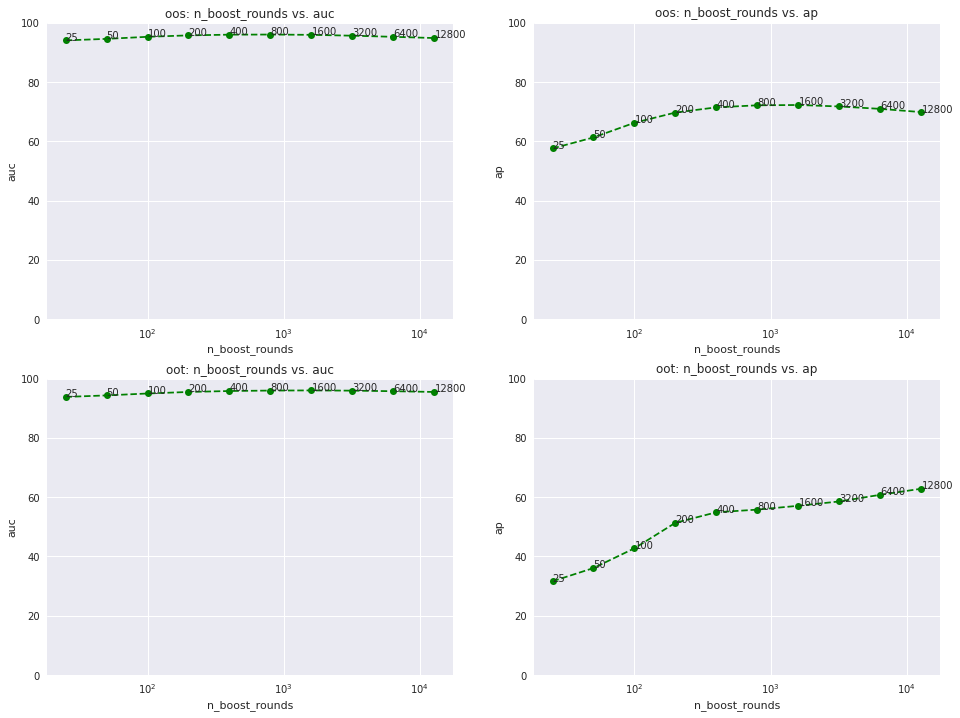

In [169]:
import matplotlib.ticker as mticker

x = 'n_boost_rounds'
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
data = [(metrics_oos, 'auc', 'oos'), (metrics_oos, 'ap', 'oos'), 
        (metrics_oot, 'auc', 'oot'), (metrics_oot, 'ap', 'oot')]

for (metrics, y, type_), ax in zip(data, axs.flatten()):
    fig = ax.plot(metrics[x], metrics[y], 'go--')

    for i, txt in enumerate(metrics[x]):
        ax.annotate(txt, (metrics[x][i], metrics[y][i]))

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_ylim(0, 100)
    ax.set_xscale('log')
    ax.set_title(f'{type_}: {x} vs. {y}')
plt.show()

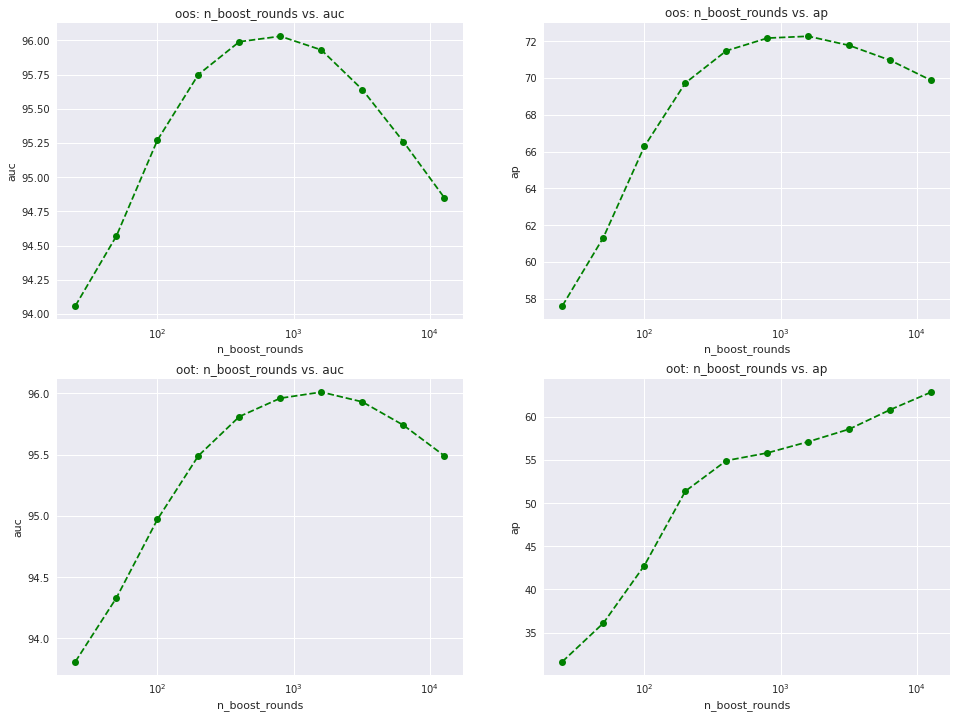

In [170]:
x = 'n_boost_rounds'
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
data = [(metrics_oos, 'auc', 'oos'), (metrics_oos, 'ap', 'oos'), 
        (metrics_oot, 'auc', 'oot'), (metrics_oot, 'ap', 'oot')]

for (metrics, y, type_), ax in zip(data, axs.flatten()):
    fig = ax.plot(metrics[x], metrics[y], 'go--')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xscale('log')
    ax.set_title(f'{type_}: {x} vs. {y}')
plt.show()